In [1]:
!pip install torch torchvision torchaudio

## 機械翻訳

系列データに関する手法の基本的な活用例としては機械翻訳があります。これは系列データを入力し、系列データを出力する Sequence to Sequence の手法によって行えます。


### 【問題1】機械翻訳の実行とコードリーディング

以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。

https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
import os
os.chdir('../../../../../')

In [4]:
pwd

'/'

In [8]:
import os

os.chdir('/Users/SHOTA/diveintocode-ml')

# カレントディレクトリの取得
print(os.getcwd())

/Users/SHOTA/diveintocode-ml


In [9]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://raw.githubusercontent.com/L1aoXingyu/seq2seq-translation/master/data/eng-fra.txt
http://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# データをベクトル化する
input_texts = []#英語
target_texts = []#フランス語
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # 「タブ」を「開始シーケンス」文字として使用しています。
    # targetsと "\n" は"end sequence" として見なす.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_dataはdecoder_input_dataより1タイムステップ進んでいます。
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_dataは1タイムステップ先になります。
            # 開始文字は含まない
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# エンコーダーの出力は破棄し、状態のみを保持する。
encoder_states = [state_h, state_c]

# 初期状態として `encoder_states` を用いてデコーダをセットアップします。
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# 完全な出力シーケンスを返すようにデコーダを設定し、内部状態も返すようにしました。
# 学習モデルでは戻り状態は使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# ターンするモデルを定義する
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# トレーニング
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
#モデルを保存
model.save('s2s.h5')

# ここから推論モデルを作る
# Here's the drill:
# 1) 入力を符号化し、初期デコーダ状態を取得します。
# 2) この初期状態でデコーダの1ステップを実行します。
# そして "シーケンスの開始 "トークンをターゲットにしています。
# 出力結果がhe next target tokenにまるでしょう。
# 3) 現在のターゲットトークンと現在の状態を繰り返します。

# サンプリングモデルの定義
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# シーケンスを読み取り可能なものにデコードするための逆引きトークンインデックス
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # 入力を状態ベクトルとしてエンコードします。
    states_value = encoder_model.predict(input_seq)

    # 長さ1の空のターゲットシーケンスを生成します
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # ターゲットシーケンスの最初の文字に開始文字を入れます。
    target_seq[0, 0, target_token_index['\t']] = 1.

    # １バッチのシーケンスのためのサンプリングループ
    # (簡略化するために，ここではサイズ 1 のバッチを想定します．).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 終了条件: どちらかの長さに達するか、あるいは、終了条件を見つけるまで
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # ターゲットシーケンス(長さ1)を更新
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 状態の更新
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # out decodingを試すために1つのシーケンス（訓練テストの一部）を取る
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Using TensorFlow backend.


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 91
Max sequence length for inputs: 16
Max sequence length for outputs: 59





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 50s 6ms/step - loss: 0.9341 - val_loss: 0.9658
Epoch 2/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.7352 - val_loss: 0.7905
Epoch 3/100
8000/8000 [==============================] - 38s 5ms/step - loss: 0.6237 - val_loss: 0.7316
Epoch 4/100
8000/8000 [==============================] - 39s 5ms/step - loss: 0.5665 - val_loss: 0.6780
Epoch 5/100
8000/8000 [==============================] - 42s 5ms/step - loss: 0.5272 - val_loss: 0.6406
Epoch 6/100
8000/8000 [==============================] - 43s 5ms/step - loss: 0.4959 - val_loss: 0.6106
Epoch 7/100
8000/8000 [==============================] - 43s 5m

8000/8000 [==============================] - 37s 5ms/step - loss: 0.1076 - val_loss: 0.6382
Epoch 62/100
8000/8000 [==============================] - 36s 4ms/step - loss: 0.1058 - val_loss: 0.6447
Epoch 63/100
8000/8000 [==============================] - 36s 4ms/step - loss: 0.1040 - val_loss: 0.6489
Epoch 64/100
8000/8000 [==============================] - 37s 5ms/step - loss: 0.1023 - val_loss: 0.6504
Epoch 65/100
8000/8000 [==============================] - 36s 4ms/step - loss: 0.1003 - val_loss: 0.6545
Epoch 66/100
8000/8000 [==============================] - 37s 5ms/step - loss: 0.0987 - val_loss: 0.6676
Epoch 67/100
8000/8000 [==============================] - 36s 4ms/step - loss: 0.0971 - val_loss: 0.6676
Epoch 68/100
8000/8000 [==============================] - 36s 4ms/step - loss: 0.0955 - val_loss: 0.6682
Epoch 69/100
8000/8000 [==============================] - 37s 5ms/step - loss: 0.0937 - val_loss: 0.6775
Epoch 70/100
8000/8000 [==============================] - 36s 5ms/st

/Users/SHOTA/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Run!
Decoded sentence: Cours !

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: I see.
Decoded sentence: Je vois une rose.

-
Input sentence: I try.
Decoded sentence: Je plaisante.

-
Input sentence: I won!
Decoded sentence: Je l'ai emporté !

-
Input sentence: I won!
Decoded sentence: Je l'ai emporté !

-
Input sentence: Oh no!
Decoded sentence: On ne sui pas avicé !

-
Input sentence: Attack!
Decoded sentence: Attaquez !

-
Inpu

LSTMの

## イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。

https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。


### 【問題2】イメージキャプショニングの学習済みモデルの実行

上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。


In [10]:
!git clone https://github.com/pdollar/coco.git

fatal: destination path 'coco' already exists and is not an empty directory.


In [11]:
cd coco/PythonAPI/

/Users/SHOTA/diveintocode-ml/coco/PythonAPI


In [12]:
!python setup.py build
!python setup.py install

running build
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.7-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.macosx-10.7-x86_64/egg
copying build/lib.macosx-10.7-x86_64-3.7/.DS_Store -> build/bdist.macosx-10.7-x86_64/egg
creating build/bdist.macosx-10.7-x86_64/egg/pycocotools
copying build/lib.macosx-10.7-x86_64-3.7/pycocotools/coco.py -> build/bdist.macosx-10.7-x86_64/egg/pycocotools
copying build/lib.m

In [13]:
cd ../../

/Users/SHOTA/diveintocode-ml


In [14]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [15]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/SHOTA/diveintocode-ml/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [16]:
ls

README.md         data_loader.py    models/           resize.py
build_vocab.py    download.sh*      png/              sample.py
data/             model.py          requirements.txt  train.py


In [17]:
!pip install -r requirements.txt

In [18]:
!chmod +x download.sh

In [19]:
!./download.sh

mkdir: data: File exists
./download.sh: line 2: wget: command not found
./download.sh: line 3: wget: command not found
./download.sh: line 4: wget: command not found
unzip:  cannot find or open ./data/captions_train-val2014.zip, ./data/captions_train-val2014.zip.zip or ./data/captions_train-val2014.zip.ZIP.
rm: ./data/captions_train-val2014.zip: No such file or directory
unzip:  cannot find or open ./data/train2014.zip, ./data/train2014.zip.zip or ./data/train2014.zip.ZIP.
rm: ./data/train2014.zip: No such file or directory
unzip:  cannot find or open ./data/val2014.zip, ./data/val2014.zip.zip or ./data/val2014.zip.ZIP.
rm: ./data/val2014.zip: No such file or directory


In [20]:
# modelsフォルダを作成して、その中でpretrained_model.zipを解凍
!mkdir models

mkdir: models: File exists


In [21]:
cd models

/Users/SHOTA/diveintocode-ml/pytorch-tutorial/tutorials/03-advanced/image_captioning/models


In [22]:
#!unzip pretrained_model.zip

unzip:  cannot find or open pretrained_model.zip, pretrained_model.zip.zip or pretrained_model.zip.ZIP.


In [24]:
# dataフォルダの中でvocap.zipを解凍
#cd /content/drive/MyDrive/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/data_path

In [25]:
#!unzip vocap.zip

In [32]:
cd /Users/SHOTA/diveintocode-ml/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning

/Users/SHOTA/diveintocode-ml/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


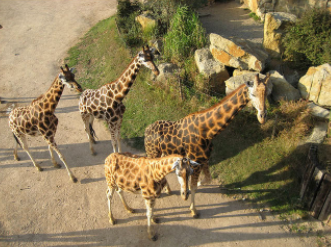

In [34]:
from PIL import Image

#jpgデータを読み込みます
img = Image.open('/Users/SHOTA/diveintocode-ml/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png')
img

In [35]:
!python sample.py --image='png/example.png'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/SHOTA/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|████████████████████████████████████████| 230M/230M [00:19<00:00, 12.5MB/s]
<start> a group of giraffes standing next to each other . <end>


**自分の用意した画像で文章を生成**

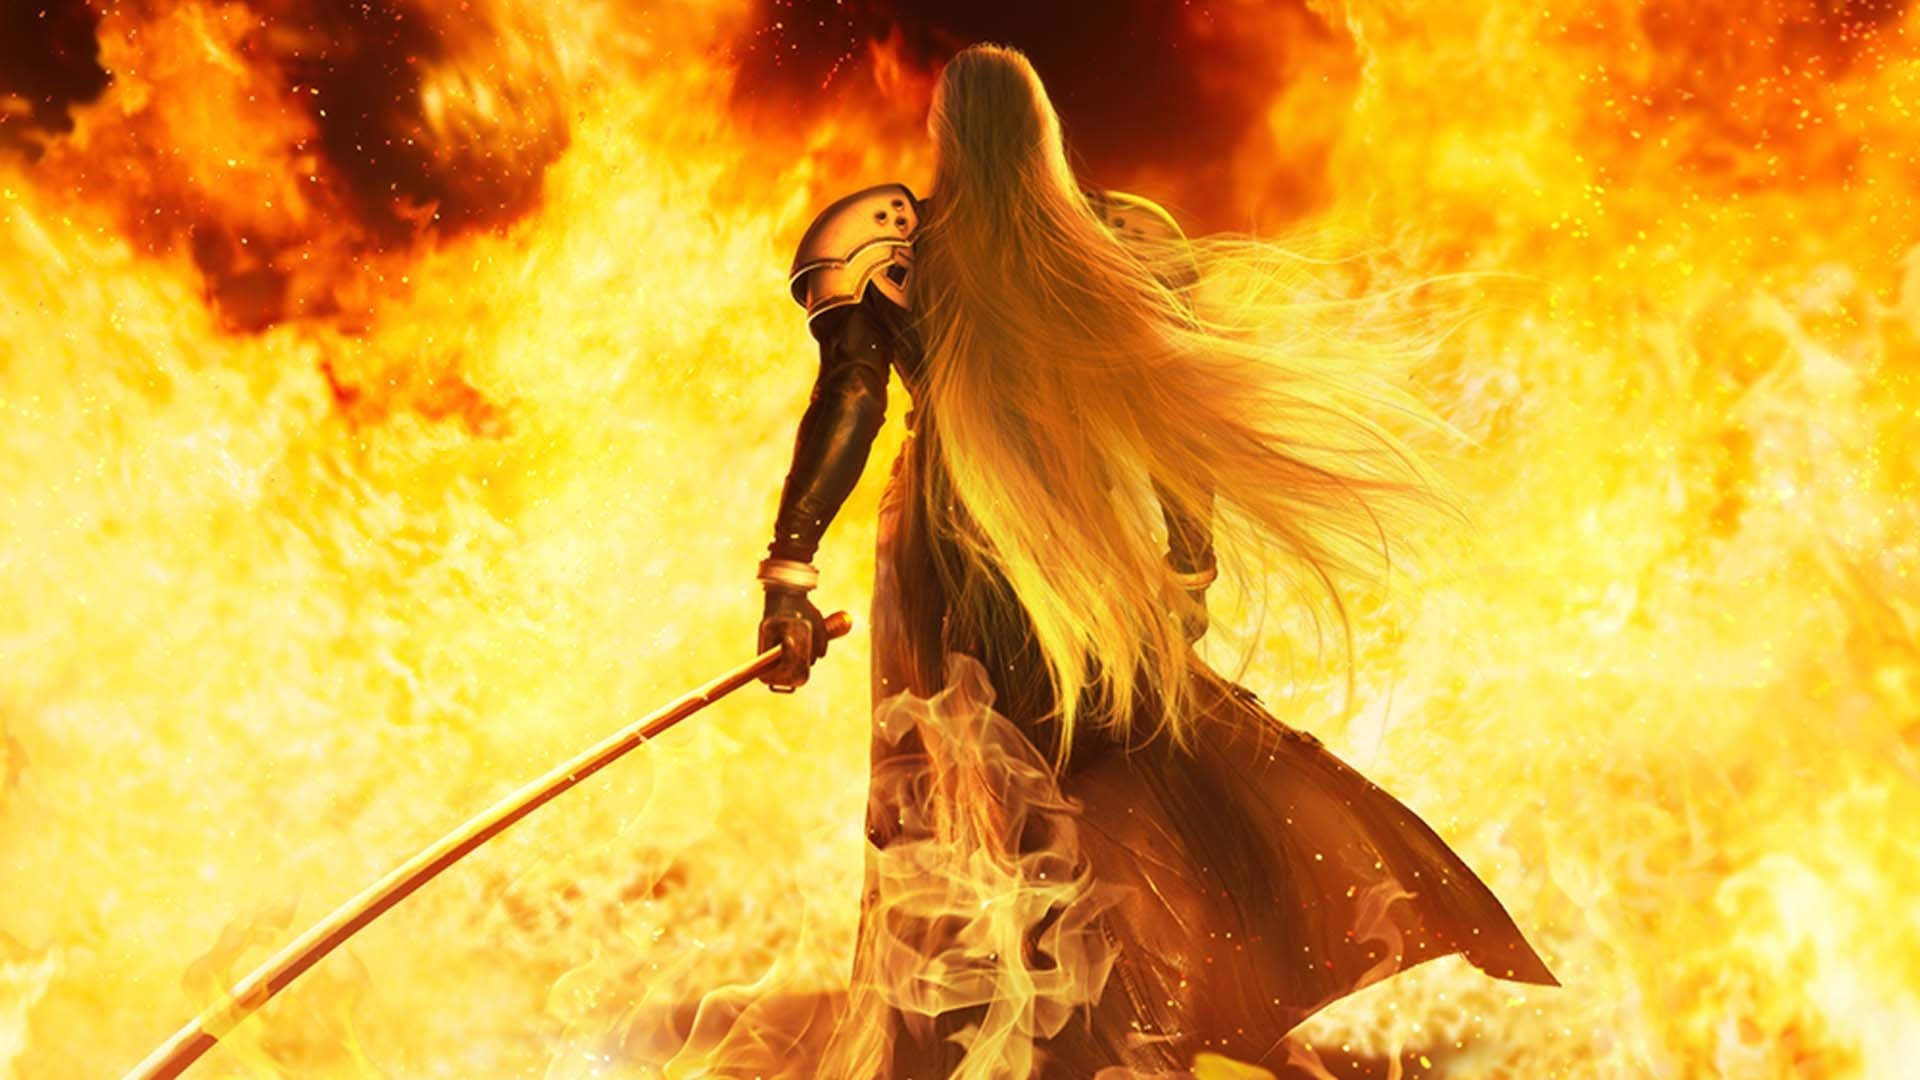

In [36]:
from PIL import Image

#jpgデータを読み込みます
img = Image.open('/Users/SHOTA/diveintocode-ml/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example2.jpg')
img


In [38]:
!python sample.py --image='png/example2.jpg'

<start> a woman with a hat and a hat on a cell phone . <end>


**全然違うキャプションがついた。。**

### 【問題3】Kerasで動かしたい場合はどうするかを調査

PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

- PyTorch側での重み保存
torch-hdf5を使用して.h5で保存する。

- Kerasでの重みの使用
.h5ファイルを読み込む。

- 深層学習モデルの相互変換ツールMMdnnを使用する
Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール
https://github.com/Microsoft/MMdnn

- PyTorch to Keras model converter(pytorch2keras)
https://pypi.org/project/pytorch2keras/0.1.6/